# Imports classiques
Nous allons tout d'abord lancer les imports classiques

In [2]:
%load_ext autoreload
%autoreload 2
%matplotlib inline
import numpy as np
import matplotlib.pyplot as plt
import Optim as opt
import functions as func

In [3]:
def contour_and_f_plot(res,function, levels=None,xmin=-2,xmax=2,ymin=-2,ymax=2):
    xiter=np.array(res['list_x'])
    fig, axarr = plt.subplots(2, 2, figsize=(16,8))
    # First plot 
    axarr[0,0].set_title('Points and levelset')
    Nx = 1000
    Ny = 1000
    x = np.linspace(xmin,xmax,Nx)
    y = np.linspace(ymin,ymax,Ny)
    X, Y = np.meshgrid(x, y)
    Z=function.value((X,Y))
    if levels:
        CS = axarr[0,0].contour(X, Y, Z, levels)
    else:
        CS = axarr[0,0].contour(X, Y, Z)
    axarr[0,0].plot(xiter[:,0], xiter[:,1],'+')
    axarr[0,0].clabel(CS, inline=1, fontsize=10)
    axarr[0,0].axis('equal')
    # Second plot
    axarr[0,1].set_title('Evolution of the cost')
    fiter=np.array(res['list_costs'])
    if min(fiter) > 0:
        axarr[0,1].semilogy(fiter)
    else:
        axarr[0,1].plot(fiter)
    #Third plot
    axarr[1,0].set_title('Norm of the gradient')
    giter=np.array(res['list_grads'])
    axarr[1,0].semilogy(giter)
    #Fourth plot
    axarr[1,1].set_title('Steps')
    siter=np.array(res['list_steps'])
    axarr[1,1].plot(siter)
    plt.show()


## L-BFGS
Nous allons nous intéresser à l'algorithme Limited Memory BFGS. Cet algorithme est du type BFGS, c'est à dire qu'il estime l'inverse de la Hessienne de $f$. Le L dans le nom de l'algorithme signifie qu'il est à mémoire limitée, c'est à dire qu'il ne garde en mémoire que les $L$ dernières itérations de calcul pour estimer la Hessienne.
L'algorithme est le suivant : Nous sommes à l'itération $k$, nous notons $x_k$ l'itéré et nous avons stocké les vecteurs suivants pour tout $k_{min}\le i\le k$.
$$ \sigma_i=x_{i}-x_{i-1} \text{ et } y_i=\nabla f(x_{i}) -\nabla f(x_{i-1})$$
Et on a aussi stocké $\rho_i=\frac{1}{(\sigma_i,y_i)}$. Tous les $\rho_i$ doivent être positifs.
L'algorithme est le suivant 

$q=-\nabla f(x_k)$<br>
Pour $i=k,k-1,\dots k_{min}$<br>
&nbsp;&nbsp;&nbsp;&nbsp;$\alpha_i=\rho_i(\sigma_i \cdot q)$<br>
&nbsp;&nbsp;&nbsp;&nbsp;$q=q-\alpha_i y_i$<br>
$q=\displaystyle \frac{(\sigma_{k_{min}}\cdot y_{k_{min}})}{(y_{k_{min}}\cdot y_{k_{min}})}q$<br>
Pour $i=k_{min},k_{min}+1,\dots,k$<br>
&nbsp;&nbsp;&nbsp;&nbsp;$\beta_i=\rho_i(y_i\cdot r)$<br>
&nbsp;&nbsp;&nbsp;&nbsp;$q=q+(\alpha_i-\beta_i)\sigma_i$<br>
rend r
</div>



# Fonctions sur les listes
Vous aurez sans doute besoin des fonctions suivantes pour les listes

In [4]:
a=[(2*i,3*i) for i in range(5) ]
print(a)
print(a[3],a[-1])
print('*** Pop ***')
a.pop(0)
print(a)
print('*** Parcours ***')
for e,f in a :
      print(e,'et',f)
print('*** Parcours Inverse***')
for e in reversed(a) :
      print(e)
b=[e**2 for e,f in a]
print(b)
print('*** Parcours de deux listes ensembles***')
for (m,(t,p)) in zip(b,a) :
    print(m,'et',t,'et encore',p)
print('*** Append ***')
print(b)
b.append(546)
print(b)
print('*** Inversion ***')
c=list(reversed(b))
print(c)
print(len(b))

[(0, 0), (2, 3), (4, 6), (6, 9), (8, 12)]
(6, 9) (8, 12)
*** Pop ***
[(2, 3), (4, 6), (6, 9), (8, 12)]
*** Parcours ***
2 et 3
4 et 6
6 et 9
8 et 12
*** Parcours Inverse***
(8, 12)
(6, 9)
(4, 6)
(2, 3)
[4, 16, 36, 64]
*** Parcours de deux listes ensembles***
4 et 2 et encore 3
16 et 4 et encore 6
36 et 6 et encore 9
64 et 8 et encore 12
*** Append ***
[4, 16, 36, 64]
[4, 16, 36, 64, 546]
*** Inversion ***
[546, 64, 36, 16, 4]
5


# Class BFGS
Créez une classe `BFGS` dans `Optim.py`, sa fonction `__init__` sera de la forme 
`__init__(self,nb_stock_max=8)` où `nb_stock_max` est le nombre maximum d'itérations prises en compte. Cette fonction créera aussi une liste vide appelée `stock` qui conserve les $\sigma_i,y_i,\rho_i$. Elle devra aussi créer une liste vide nommée `last_iter`.


# Push
Nous allons maintenant créer une fonction `push(self, x, grad)` qui enregistre $s\sigma_k,y_k,\rho_k$. Pour cela, on a besoin de $x_{k-1},\nabla f(x_{k-1})$. Si ils existent, ils se trouvent dans la liste `self.last_iter`. Ensuite on peut calculer $\sigma_k,y_k$ et $\rho_k$. 

Si $\rho_k$ est positif, alors on enregistre le triplet $(\sigma_k,y_k,\rho_k)$ à la fin de la liste `self.stock`, en vérifiant `self.stock` ne doit contenir au maximum que les dernières `self.nb_stock_max` itérations (si nécessaire on retire le tout premier élément de `self.stock`). 

Si $\rho_k$ est négatif, quelquechose c'est mal passé, on vide le `self.stock`.

A la fin, on n'oublie pas de mettre $x_{k}$ et $\nabla f(x_{k})$ dans `self.last_iter` pour être sûr de les y trouver la prochaine fois.

# Get

Nous allons maintenant créer une fonction `get(self, grad)` qui modifie la direction de descente et applique l'algorithme ci-dessus. Cette fonction doit nous rendre le `r` final. Si le `self.stock` est vide, cette fonction doit nous rendre `-grad`

# dc

Nous créeons maintenant une fonction `dc(self,x,function,df)` qui appplique tout d'abord `self.push` puis `self.get`, elle rend le résultat de la fonction de `self.get` et une variable d'info.

# C'est l'heure de tester ...
Lancez une méthode de Newton_Wolfe sur votre fonction préférée et à chaque itération calculez ce que donnerait un L-BFGS. Comparez les angles des directions entre la méthode de Newton et le L-BFGS, comparez aussi le ration des normes. Ensuite lancez un LBFGS avec recherche de pas de Wolfe sur vos tests préférez et obtenez le comportement de Newton_Wolfe sans le calcul de la Hessienne...


Fonction (x,y) --> 100*(y-x²)²+(1-x)²
iter=   0 f=4.040e+02 df=8.980e+02 comp=[   1,   1,   0]
-0.4476734786994657
iter=   1 f=3.980e+00 df=4.000e+00 comp=[   2,   2,   1]
-0.44789477971528446
iter=   2 f=3.431e+00 df=2.512e+01 comp=[   6,   3,   2]
-0.25804832831514374
iter=   3 f=2.640e+00 df=8.222e+00 comp=[   7,   4,   3]
-0.2663317683958152
iter=   4 f=2.230e+00 df=1.310e+01 comp=[   9,   5,   4]
-0.3366022238024298
iter=   5 f=1.695e+00 df=7.019e+00 comp=[  10,   6,   5]
-0.39621808950587006
iter=   6 f=1.368e+00 df=1.056e+01 comp=[  11,   7,   6]
-0.6470490092848902
iter=   7 f=9.310e-01 df=2.550e+00 comp=[  12,   8,   7]
-0.7685026493983937
iter=   8 f=7.368e-01 df=6.790e+00 comp=[  14,   9,   8]
-0.44319232565323047
iter=   9 f=4.843e-01 df=2.121e+00 comp=[  15,  10,   9]
-0.5781579001038826
iter=  10 f=3.640e-01 df=3.924e+00 comp=[  17,  11,  10]
-0.29635978225764736
iter=  11 f=2.289e-01 df=4.303e+00 comp=[  18,  12,  11]
-0.20557445504634345
iter=  12 f=1.306e-01 df=3.058e+

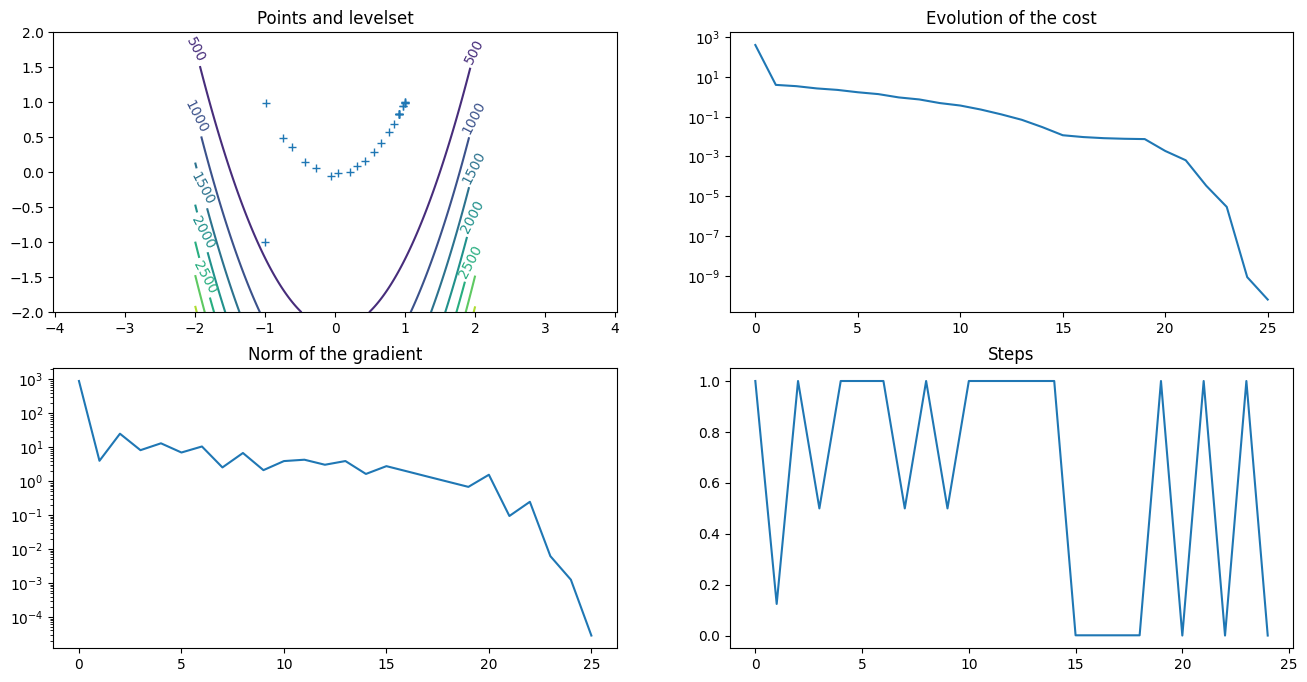

['newton', 'newton', 'newton', 'newton', 'newton', 'newton', 'newton', 'newton', 'newton', 'newton', 'newton', 'newton', 'newton', 'newton', 'newton', 'gradient', 'gradient', 'gradient', 'gradient', 'newton', 'gradient', 'newton', 'gradient', 'newton', 'gradient']


In [9]:
f=func.Rosen()
x0=np.array([-1,-1])
res=opt.main_algorithm(f,0.1,x0,ls=opt.ls_wolfe_step_is_one,dc=opt.dc_Newton,verbose=True)
contour_and_f_plot(res,f)
print(res['dc'])

Fonction (x,y) --> 100*(y-x²)²+(1-x)²
iter=   0 f=4.040e+02 df=8.980e+02 comp=[   1,   1,   0]
iter=   1 f=2.978e+01 df=1.644e+02 comp=[  11,   2,   0]
iter=   2 f=3.519e+00 df=4.437e+01 comp=[  12,   3,   0]
iter=   3 f=6.637e-01 df=1.092e+01 comp=[  13,   4,   0]
iter=   4 f=4.552e-01 df=1.283e+00 comp=[  14,   5,   0]
iter=   5 f=4.516e-01 df=1.143e+00 comp=[  15,   6,   0]
iter=   6 f=4.458e-01 df=1.518e+00 comp=[  16,   7,   0]
iter=   7 f=4.275e-01 df=2.754e+00 comp=[  17,   8,   0]
iter=   8 f=1.789e-01 df=4.143e+00 comp=[  20,  11,   0]
iter=   9 f=1.755e-01 df=1.807e+00 comp=[  22,  12,   0]
iter=  10 f=1.544e-01 df=1.947e+00 comp=[  23,  13,   0]
iter=  11 f=1.221e-01 df=8.741e+00 comp=[  24,  14,   0]
iter=  12 f=7.946e-02 df=4.870e-01 comp=[  25,  15,   0]
iter=  13 f=5.721e-02 df=4.853e-01 comp=[  26,  16,   0]
iter=  14 f=4.109e-02 df=5.129e+00 comp=[  28,  17,   0]
iter=  15 f=2.735e-02 df=1.166e+00 comp=[  29,  18,   0]
iter=  16 f=1.570e-02 df=4.802e-01 comp=[  30,  19

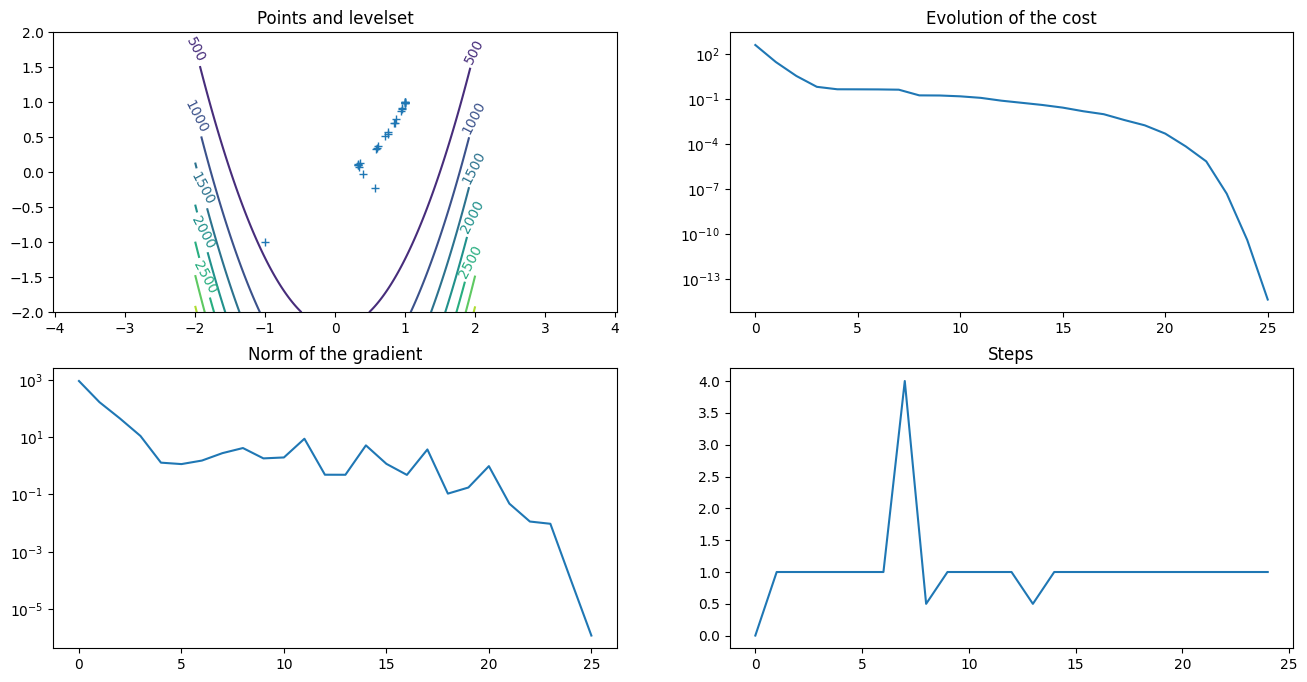

In [17]:
f=func.Rosen()
B=opt.BFGS(nb_stock_max=12)
x0=np.array([-1,-1])
res=opt.main_algorithm(f,0.1,x0,ls=opt.ls_wolfe_step_is_one,dc=B.dc,verbose=True)
contour_and_f_plot(res,f)